In [2]:
print(sc.uiWebUrl)

http://midway3-0066.rcc.local:4040


In [2]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          40695181   caslake _interac    yjia2  R      30:25      1 midway3-0066


In [3]:
from pyspark.sql import functions as F, types as T
from pyspark.storagelevel import StorageLevel
from pyspark.ml.feature import Word2VecModel
from pyspark.ml.feature import Word2Vec
from pyspark.sql import SparkSession

In [16]:
BASE_PATH = "cleaned_segmented_parquet"
df = spark.read.parquet(BASE_PATH)

df = (df.withColumnRenamed("文本内容_清洗", "content_cleaned")
        .withColumnRenamed("年份", "year"))

df = df.select("content_cleaned", "year")

# Ensure that year is an integer.
df = df.withColumn("year", F.col("year").cast("int"))

print("Columns now:", df.columns)
df.printSchema()
df.show(5, truncate=80)

Columns now: ['content_cleaned', 'year']
root
 |-- content_cleaned: string (nullable = true)
 |-- year: integer (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------+----+
|                                                                                                                        content_cleaned|year|
+---------------------------------------------------------------------------------------------------------------------------------------+----+
| 首届 动漫 版权保护 贸易 博览会 本报 广州 月 日电 记者 吴冰 贺林平 首届 中国 国际 影视 动漫 版权保护 贸易 博览会 东莞 这是 全国 第一...|2010|
|    数字 点击 成就 万吨 截至 年 月 日 大庆油田 年 生产 原油 万吨 天然气 亿立方米 原油 万吨 稳产 年 汪 波 宝 峰 亿元 财政部 会同 民政...|2010|
|     福建 铁路 三线 开通 六线 一站 开工 年 月 日 福厦 铁路 开通 建设者 欢呼雀跃 当日 福建 温 州 福 州 铁路 福厦 铁路 横 峰福 州 铁路...|2010|
|强化 廉政 意识 弘扬 新风 正气 深入开展 反腐倡廉 二 九年 反腐倡廉 宣传教育 工作 综述 本报记者 姜 洁 年 纪检监察 机关 贯彻落实 科学 发...|2010|
|   汽车 以旧换新 补贴 标准 上限 提高 万元 已 按原 标准 领取 补贴 车主 获补 差额 本报 北京 月 日电 记者 崔鹏 完善 汽车 以旧换新 

In [17]:
# --- 1) content_cleaned -> tokens (array) ---
df = df.withColumn("content_cleaned", F.trim(F.col("content_cleaned")))
df = df.filter(F.col("content_cleaned").isNotNull() 
               & (F.length("content_cleaned") > 0))

# Split the tokens into arrays based on blank spaces and remove any empty tokens.
df = df.withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
df = df.withColumn("tokens", F.expr("filter(tokens, x -> x <> '')"))

# ---2) Filter invalid samples (discard sentences with a length < 3).---
df = df.withColumn("len_tokens", F.size(F.col("tokens")))
df = df.filter(F.col("len_tokens") >= 3).drop("len_tokens")

df = df.select("year", "content_cleaned", "tokens")

# --- 3) Annual Coverage Check---
year_stats = (
    df.groupBy("year")
      .agg(
          F.count("*").alias("n_docs"),
          F.sum(F.size("tokens")).alias("n_tokens") 
      )
      .orderBy("year")
)

year_stats.show(5, truncate=False)

[Stage 15:=====================================================>(250 + 1) / 251]

+----+------+--------+
|year|n_docs|n_tokens|
+----+------+--------+
|1947|10769 |2711874 |
|1948|8246  |2296198 |
|1949|18956 |5181229 |
|1950|19990 |6268532 |
|1951|13756 |5049297 |
+----+------+--------+
only showing top 5 rows



In [ ]:
W2V_PARAMS = dict(
    vectorSize=150,    
    windowSize=6,      
    minCount=30,       
    maxIter=3,         # epochs
    stepSize=0.025,    # Learning rate
    numPartitions=100,  
    maxSentenceLength=600,  
    seed=42,
    inputCol="tokens",
    outputCol="w2v_features" 
)

In [ ]:
df_train = df.select("tokens")                     

# Memory + Disk (Serialization)
df_train = df_train.persist(StorageLevel.MEMORY_AND_DISK)   

w2v = Word2Vec(**W2V_PARAMS)
w2v_model = w2v.fit(df_train)

# Release the training corpus cache after training is complete.
df_train.unpersist()   

# Disk Layout (Model + Word Vector Table)
MODEL_DIR = "w2v_models/pd_w2v_vs200_mc10_ep5_ws8" 
w2v_model.write().overwrite().save(MODEL_DIR)

vecs = w2v_model.getVectors()   # [word: string, vector: vector]
vecs.write.mode("overwrite").parquet(f"{MODEL_DIR}/vectors_parquet")

[Stage 8:>                                                       (0 + 32) / 251]

In [4]:
MODEL_DIR = "w2v_models/pd_w2v_vs200_mc10_ep5_ws8"

# Load trained model
w2v_model = Word2VecModel.load(MODEL_DIR)

# Load vectors table
vecs = spark.read.parquet(f"{MODEL_DIR}/vectors_parquet")

In [5]:
vecs.printSchema()
vocab_size = vecs.count()
print("vocab_size =", vocab_size)

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)

vocab_size = 270919


In [6]:
# Take one vector and print its length
sample_vec = vecs.select("vector").head()[0]
print("vector dimension =", len(sample_vec))


vector dimension = 150


In [7]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

vecs_arr = vecs.withColumn("arr", vector_to_array("vector"))

vecs_norm = vecs_arr.withColumn(
    "norm",
    F.sqrt(F.aggregate("arr", F.lit(0.0), lambda acc, x: acc + x * x))
)

vecs_norm.select(
    F.mean("norm").alias("mean_norm"),
    F.stddev("norm").alias("std_norm"),
    F.min("norm").alias("min_norm"),
    F.max("norm").alias("max_norm")
).show()


[Stage 8:>                                                        (0 + 16) / 16]

+-----------------+------------------+------------------+------------------+
|        mean_norm|          std_norm|          min_norm|          max_norm|
+-----------------+------------------+------------------+------------------+
|2.947684990033686|0.6449949248816662|0.9930399760928611|11.738858071774484|
+-----------------+------------------+------------------+------------------+



In [8]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

# --- 你想检查的词 ---
probe_words = ["人民", "民主", "国家"]

# 将 vector 列转成 array，方便计算范数
vecs_arr = vecs.withColumn("arr", vector_to_array("vector"))

# 计算 L2 norm
vecs_norm = vecs_arr.withColumn(
    "norm",
    F.sqrt(F.aggregate("arr", F.lit(0.0), lambda acc, x: acc + x * x))
)

# 建词典 {word -> norm}，用于方便查词向量长度
word_norm_dict = {
    row["word"]: row["norm"]
    for row in vecs_norm.select("word", "norm").collect()
}

# --- 逐个词检查 ---
for w in probe_words:
    print("\n" + "="*80)
    print(f"🔍 词语：{w}")

    # 1）检查是否在词表里
    if w not in word_norm_dict:
        print(f"⚠️  '{w}' 不在 vocabulary 中（可能频次 < minCount）")
        continue

    # 2）打印向量范数
    print(f"向量 L2 范数：{word_norm_dict[w]:.4f}")

    # 3）打印 Top neighbors
    print("\nTop 20 neighbors:")
    try:
        w2v_model.findSynonyms(w, 20).show(truncate=False)
    except Exception as e:
        print(f"  [Error calling findSynonyms] {e}")



🔍 词语：人民
向量 L2 范数：1.9698

Top 20 neighbors:
+------------+------------------+
|word        |similarity        |
+------------+------------------+
|同呼吸共命运|0.64397132396698  |
|依靠人民    |0.6257192492485046|
|谋利益      |0.5929797887802124|
|血肉        |0.5901146531105042|
|群众        |0.587949275970459 |
|血肉相连    |0.5877261161804199|
|深厚感情    |0.5839004516601562|
|血肉相联    |0.5778303742408752|
|亿万人民    |0.5720700025558472|
|党为        |0.5687966346740723|
|愿望        |0.5686084032058716|
|同甘苦      |0.5630213618278503|
|心心相印    |0.5627530217170715|
|正义事业    |0.5513524413108826|
|深情厚谊    |0.5489171147346497|
|党和政府    |0.5464560389518738|
|呼吸相通    |0.5457366108894348|
|迫切愿望    |0.5437646508216858|
|幸福生活    |0.543595552444458 |
|美好生活    |0.5398756265640259|
+------------+------------------+


🔍 词语：民主
向量 L2 范数：2.6638

Top 20 neighbors:
+----------+------------------+
|word      |similarity        |
+----------+------------------+
|充分发扬  |0.6594541668891907|
|民主协商  |0.6343644857406616|
|代议制    |0.6298

In [9]:
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

target_words = [
    "人民", "群众", "工人", 
    "民主", ""
]

# 1) 过滤目标词，并直接把 vector 改名为 features（保持 Vector 类型）
vecs_sub = (
    vecs
    .filter(F.col("word").isin(target_words))
    .select("word", F.col("vector").alias("features"))
)

# 2) 做 PCA（输入是 Vector）
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vecs_sub)
pca_out = pca_model.transform(vecs_sub)

# 3) 这一步才把 pca_features 变成 array，拆成 PC1/PC2
pca_out = (
    pca_out
    .withColumn("pca_arr", vector_to_array("pca_features"))
    .withColumn("PC1", F.col("pca_arr")[0])
    .withColumn("PC2", F.col("pca_arr")[1])
    .select("word", "PC1", "PC2")
)


25/11/12 17:22:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/11/12 17:22:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


  word       PC1       PC2
0   群众  0.046263  1.061553
1   人民 -0.141687  1.127149
2   民主 -2.253111 -0.257068
3   工人  0.893113 -0.931962


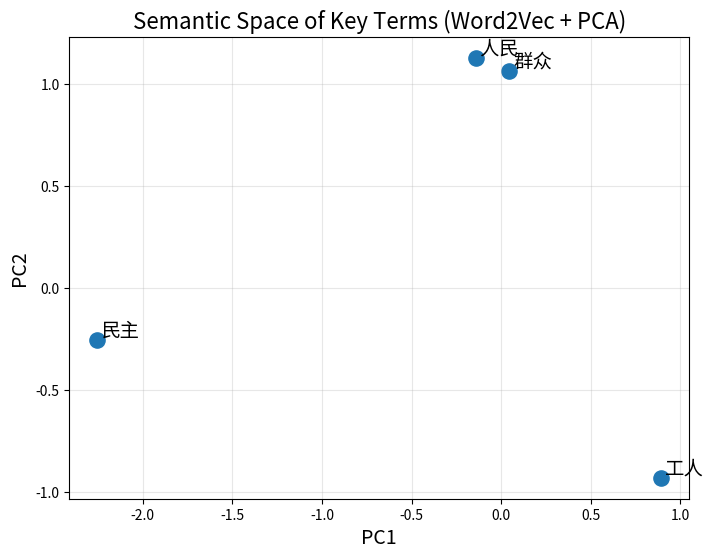

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Noto Sans CJK SC"

# 转成 pandas
pdf = pca_out.toPandas()
print(pdf)

# 画 2D 语义空间图
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pdf["PC1"], pdf["PC2"], s=120)

for _, row in pdf.iterrows():
    plt.text(row["PC1"] + 0.02, row["PC2"] + 0.02, row["word"], fontsize=14)

plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.title("Semantic Space of Key Terms (Word2Vec + PCA)", fontsize=16)
plt.grid(alpha=0.3)
plt.show()


原始词数: 214
词向量中实际存在: 170
子集规模： 169


PCA explained variance: [0.090198872859486,0.06419377081899112]


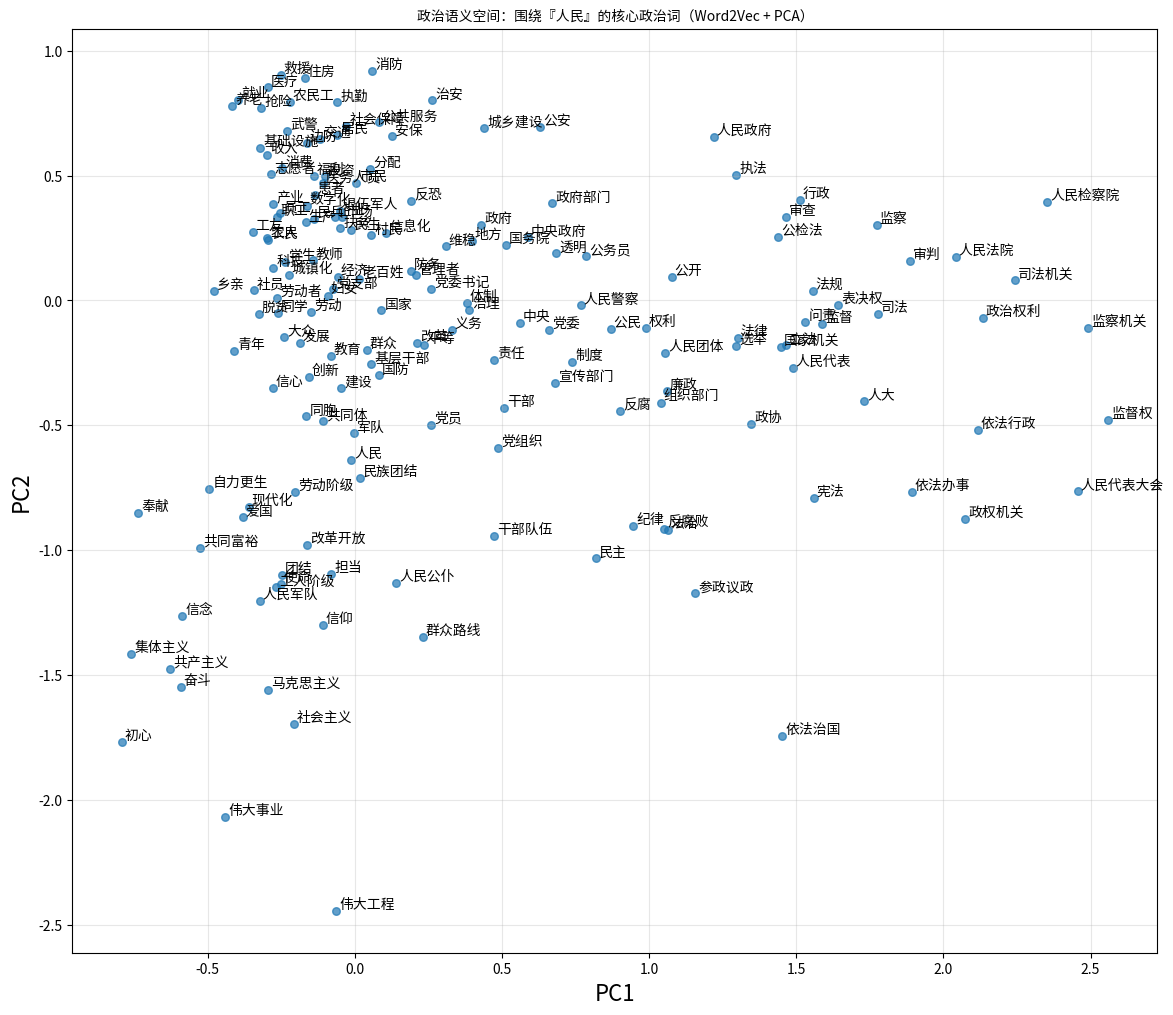

In [16]:
# =========================================
# 1. 构建手工挑选的政治语义词表（围绕“人民”）
# =========================================

target_words = [

    # 群众 / 主体 / 社会成员类
    "人民","群众","工人","农民","干部","农民工","青年","妇女","大众","职工","工友","乡亲","同胞","同学",
    "居民","公民","党员","社员","劳动者","员工","退伍军人","志愿者","基层群众","基层干部",
    "教师","医务人员","学生","患者","老百姓","村民","市民","工人阶级","劳动阶级","群众代表",
    "人民群众","人民代表","人民团体","人民子弟兵","人民军队","人民教师","人民警察","人民公仆",

    # 国家 / 政府 / 政治组织类
    "国家","政府","中央","地方","党委","党组织","基层党组织","党支部","中央政府","国务院","人大",
    "政协","党委书记","政府部门","组织部门","宣传部门","政法机关","司法机关","公检法","监察机关",
    "纪检部门","干部队伍","公务员","管理者","领导干部","人民政府","人民法院","人民检察院",
    "国家机关","国家部门","执法部门","行政机关","人民代表大会","社会主义国家","政权机关",

    # 制度 / 政治结构 / 法律类
    "民主","法治","宪法","法律","法规","制度","体制","选举","监督","纪律","问责","监察",
    "审判","审查","立法","司法","执法","行政","改革","治理","权利","义务","平等","公开","透明",
    "监督权","表决权","参政议政","依法治国","依法行政","人民主权","人民当家作主","人大制度",
    "选举制度","政治参与","政治权利","法治政府","廉政","反腐","反腐败","依法办事","程序正义",
    "社会公正","国家治理体系","国家治理能力",

    # 发展 / 建设 / 经济类
    "发展","建设","现代化","改革开放","创新","生产","经济","产业","投资","消费","市场","企业","劳动",
    "就业","脱贫","扶贫","民生","住房","教育","医疗","养老","交通","城镇化","乡村振兴","基础设施",
    "科技","数字化","信息化","高质量发展","可持续发展","经济增长","收入","分配","社会保障",
    "福利","公共服务","城乡建设","区域发展",

    # 国家叙事 / 政治价值类
    "社会主义","共产主义","马克思主义","新时代","使命","责任","担当","奋斗","奉献","团结","自力更生",
    "共同富裕","民族复兴","民族团结","伟大事业","伟大斗争","伟大工程","伟大梦想","核心价值观",
    "人民立场","人民至上","以人民为中心","群众路线","初心","使命","信仰","信念","信心","制度优势",
    "集体主义","国家利益","社会稳定","国家安全","共同体","命运共同体","爱国","责任担当",

    # 军事 / 安全 / 稳定类
    "军队","武警","民兵","国防","安全","治安","维稳","反恐","救援","抢险","边防","公安","消防",
    "执勤","人民子弟兵","安保","防务"
]

# =========================================
# 2. 过滤只保留 Word2Vec 词表中存在的词
# =========================================

from pyspark.sql import functions as F

vec_words = vecs.select("word").rdd.flatMap(lambda x: x).collect()
filtered_words = [w for w in target_words if w in vec_words]

print(f"原始词数: {len(target_words)}")
print(f"词向量中实际存在: {len(filtered_words)}")

# 构建子集 DataFrame
vecs_sub = (
    vecs.filter(F.col("word").isin(filtered_words))
        .select("word", F.col("vector").alias("features"))
)

print("子集规模：", vecs_sub.count())

# =========================================
# 3. PCA（k=2）
# =========================================

from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vecs_sub)
pca_out = pca_model.transform(vecs_sub)

# 查看解释方差
print("PCA explained variance:", pca_model.explainedVariance)

# =========================================
# 4. 提取 PC1/PC2
# =========================================

from pyspark.ml.functions import vector_to_array

pca_out = (
    pca_out
        .withColumn("pca_arr", vector_to_array("pca_features"))
        .withColumn("PC1", F.col("pca_arr")[0])
        .withColumn("PC2", F.col("pca_arr")[1])
        .select("word", "PC1", "PC2")
)

pdf = pca_out.toPandas()

# =========================================
# 5. 载入中文字体（NotoSansCJK）
# =========================================

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/home/yjia2/fonts/NotoSansCJKsc-Regular.otf"  # 改你自己路径
fm.fontManager.addfont(font_path)
zh_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = zh_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

# =========================================
# 6. 画图：政治语义空间（大型）
# =========================================

plt.figure(figsize=(14, 12))
plt.scatter(pdf["PC1"], pdf["PC2"], s=30, alpha=0.7)

# 加标签
for _, row in pdf.iterrows():
    plt.text(row["PC1"]+0.01, row["PC2"]+0.01, row["word"],
             fontsize=10, fontproperties=zh_font)

plt.title("政治语义空间：围绕『人民』的核心政治词（Word2Vec + PCA）", 
          fontsize=20, fontproperties=zh_font)
plt.xlabel("PC1", fontsize=16, fontproperties=zh_font)
plt.ylabel("PC2", fontsize=16, fontproperties=zh_font)
plt.grid(alpha=0.3)
plt.show()


Explained variance per PC (前10个): [0.09019887 0.06419377 0.05804403 0.04919009 0.04276928 0.03794403
 0.03100779 0.02863645 0.02593213 0.02322507]
Cumulative explained variance (前10个): [0.09019887 0.15439264 0.21243667 0.26162677 0.30439605 0.34234008
 0.37334788 0.40198433 0.42791646 0.45114153]
达到 80% 解释方差需要前 37 个主成分
达到 90% 解释方差需要前 None 个主成分


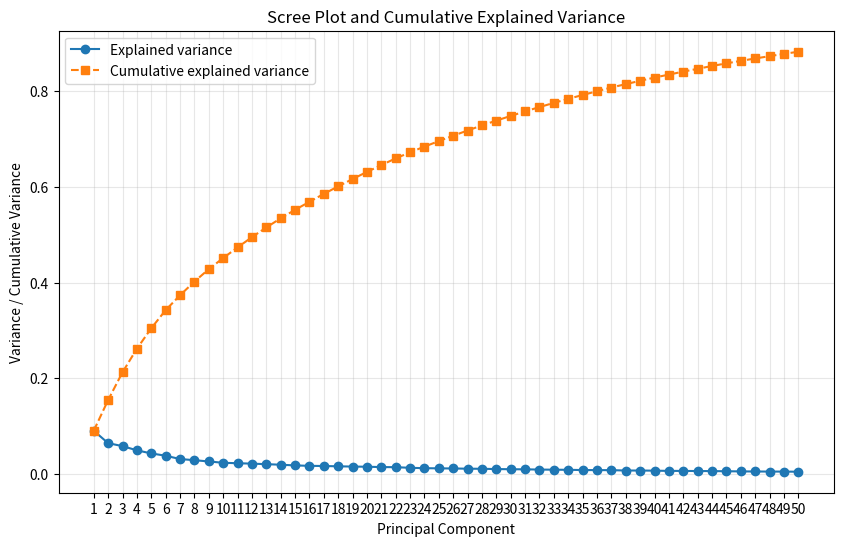

In [17]:
from pyspark.ml.feature import PCA
import numpy as np
import matplotlib.pyplot as plt

# ========= 1. 重新跑一个高维 PCA（比如 k=50） =========
# 注意：k 不能超过向量维度（你的 w2v 是 150 维），
# 也不能超过样本数-1（样本数是词个数），一般取个较小的，比如 50。
K = 50

pca_full = PCA(k=K, inputCol="features", outputCol="pca_features_full")
pca_full_model = pca_full.fit(vecs_sub)

# ========= 2. 提取 explained variance =========
ev = np.array(pca_full_model.explainedVariance.toArray())  # shape = (K,)
cum_ev = np.cumsum(ev)

print("Explained variance per PC (前10个):", ev[:10])
print("Cumulative explained variance (前10个):", cum_ev[:10])

# 简单看一眼达到 80%、90% 大概需要多少维
def find_k_for_threshold(th):
    idx = np.where(cum_ev >= th)[0]
    return int(idx[0] + 1) if len(idx) > 0 else None

k80 = find_k_for_threshold(0.80)
k90 = find_k_for_threshold(0.90)
print(f"达到 80% 解释方差需要前 {k80} 个主成分")
print(f"达到 90% 解释方差需要前 {k90} 个主成分")

# ========= 3. 画碎石图 + 累积曲线 =========
pcs = np.arange(1, K+1)

plt.figure(figsize=(10, 6))

# 左轴：每个 PC 的 explained variance（柱状或折线都可以）
plt.plot(pcs, ev, marker="o", label="Explained variance")

# 右轴：累积解释方差
plt.plot(pcs, cum_ev, marker="s", linestyle="--", label="Cumulative explained variance")

plt.xlabel("Principal Component")
plt.ylabel("Variance / Cumulative Variance")
plt.title("Scree Plot and Cumulative Explained Variance")

plt.xticks(pcs)  # 视词数和K情况，也可以改为步长显示
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [18]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F

# 3D PCA
pca3 = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca3_model = pca3.fit(vecs_sub)
pca3_out = pca3_model.transform(vecs_sub)

# 转成 PC1, PC2, PC3
pca3_out = (
    pca3_out
        .withColumn("pca_arr", vector_to_array("pca_features_3d"))
        .withColumn("PC1", F.col("pca_arr")[0])
        .withColumn("PC2", F.col("pca_arr")[1])
        .withColumn("PC3", F.col("pca_arr")[2])
        .select("word", "PC1", "PC2", "PC3")
)

pdf3 = pca3_out.toPandas()
print(pca3_model.explainedVariance)  # 看一下前三个PC的解释方差


[0.09019887285948605,0.06419377081899115,0.05804403067887266]


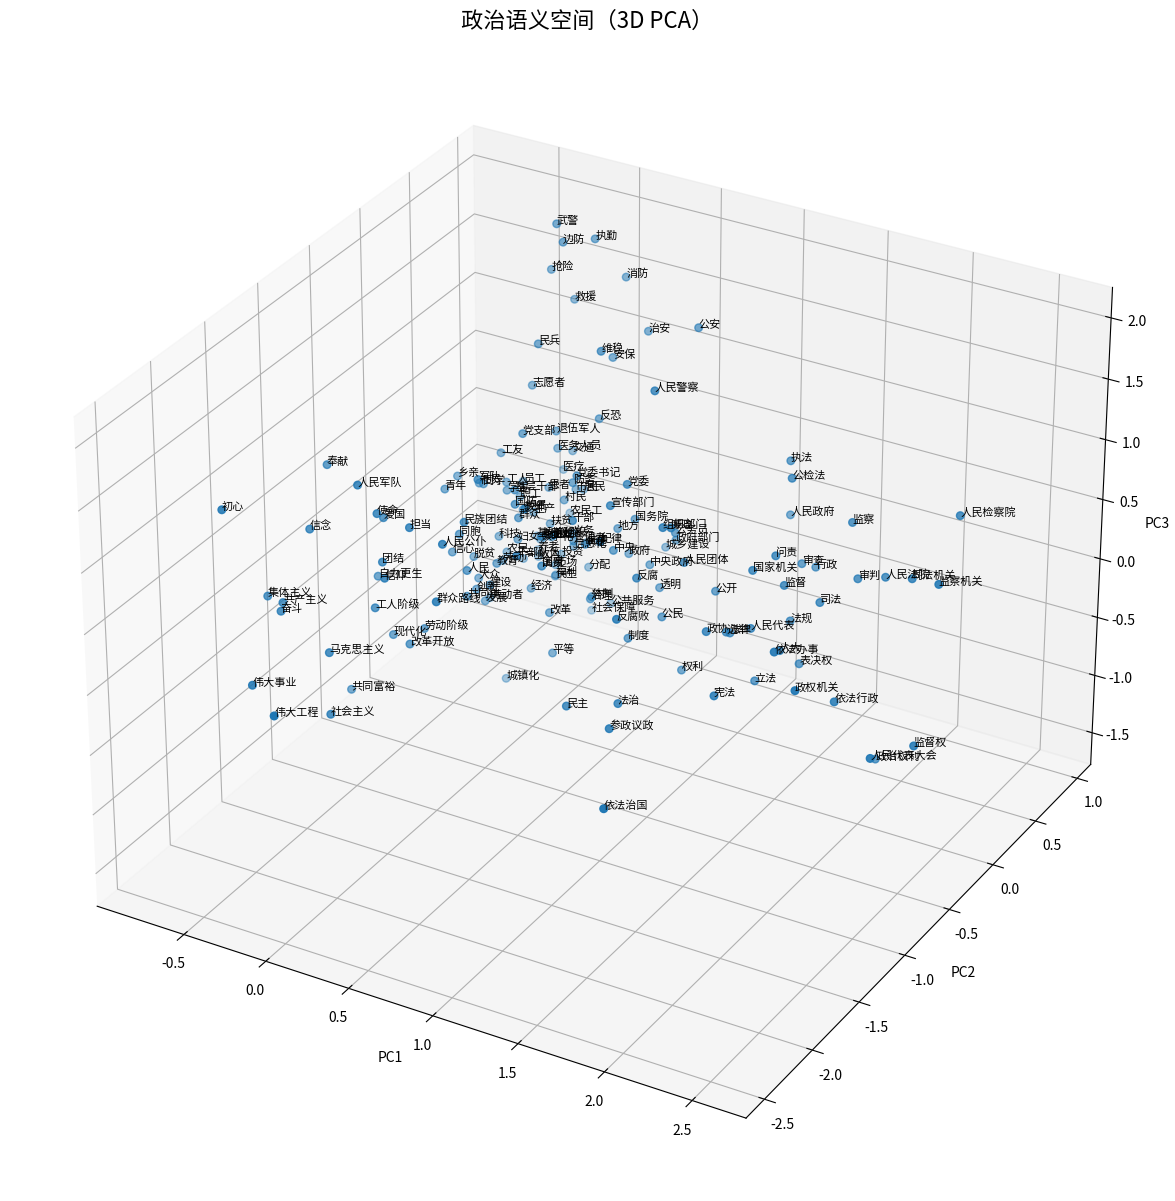

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 触发 3D 支持

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pdf3["PC1"], pdf3["PC2"], pdf3["PC3"], s=30)

# 加标签
for _, row in pdf3.iterrows():
    ax.text(row["PC1"], row["PC2"], row["PC3"], row["word"],
            fontsize=8, fontproperties=zh_font)

ax.set_xlabel("PC1", fontproperties=zh_font)
ax.set_ylabel("PC2", fontproperties=zh_font)
ax.set_zlabel("PC3", fontproperties=zh_font)
ax.set_title("政治语义空间（3D PCA）", fontproperties=zh_font, fontsize=16)

plt.show()


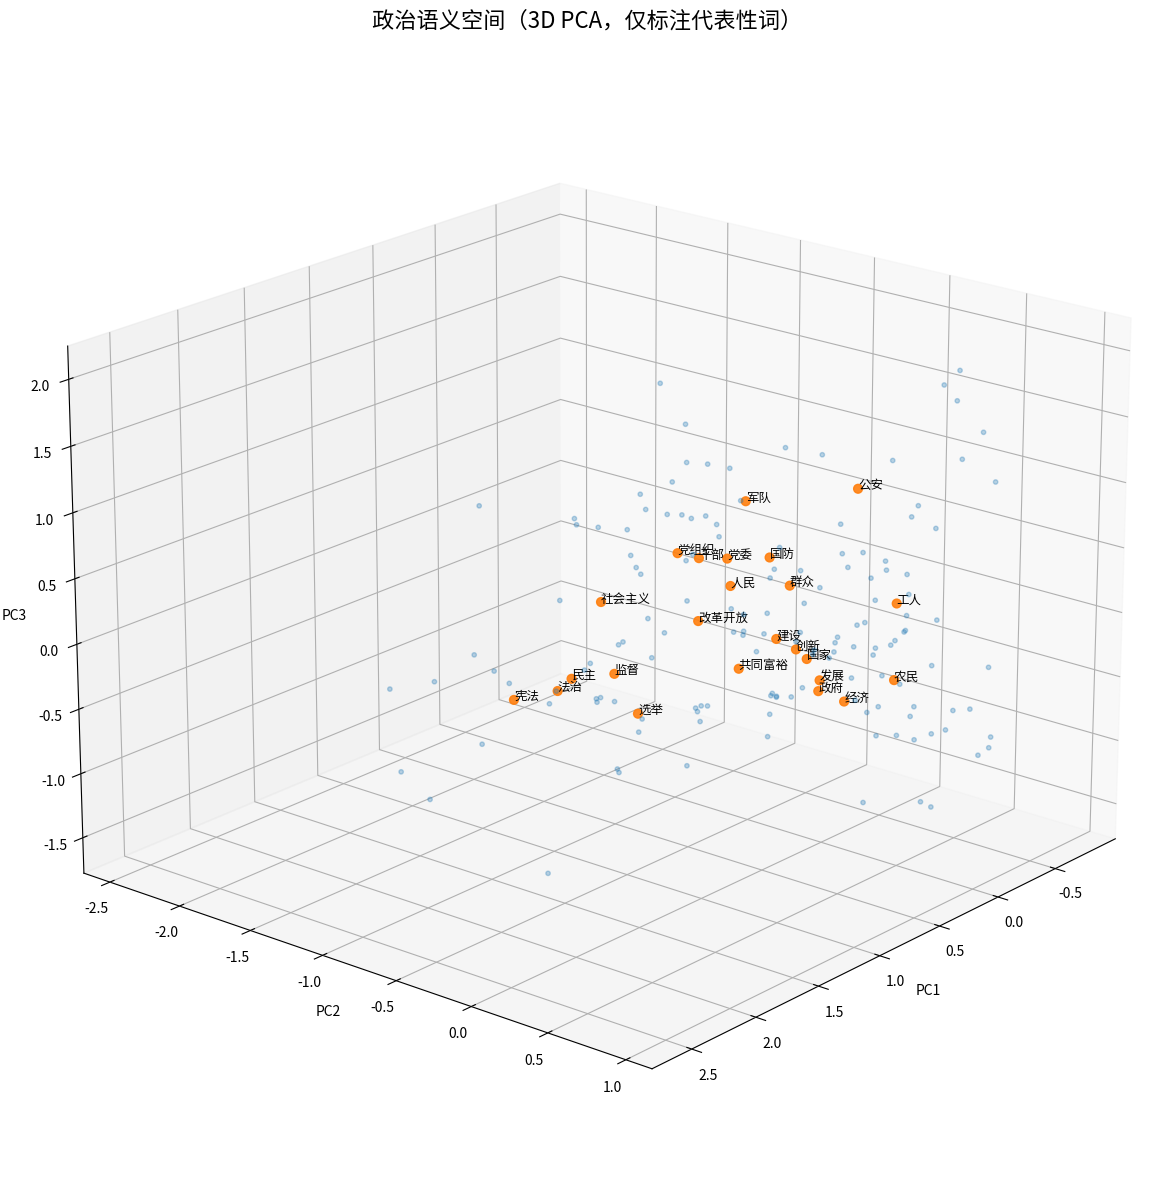

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 触发3D支持

# 1）挑一批你最关心 / 最具代表性的词打标签
highlight_words = [
    "人民","群众","工人","农民","干部",
    "国家","政府","党中央","党委","党组织",
    "民主","法治","宪法","选举","监督",
    "发展","建设","改革开放","经济","创新",
    "社会主义","新时代","共同富裕","民族复兴",
    "安全","稳定","军队","公安","国防"
]

# 分成：需要标注的一小撮 & 只当背景点的大多数
pdf3["highlight"] = pdf3["word"].isin(highlight_words)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection="3d")

# 2）先画“背景点”（不带文字，点小+透明一点）
bg = pdf3[~pdf3["highlight"]]
ax.scatter(bg["PC1"], bg["PC2"], bg["PC3"],
           s=10, alpha=0.3)

# 3）再画“高亮点”（点大一些）
fg = pdf3[pdf3["highlight"]]
ax.scatter(fg["PC1"], fg["PC2"], fg["PC3"],
           s=40, alpha=0.9)

# 4）只给高亮词加中文标签
for _, row in fg.iterrows():
    ax.text(row["PC1"], row["PC2"], row["PC3"], row["word"],
            fontsize=9, fontproperties=zh_font)

ax.set_xlabel("PC1", fontproperties=zh_font)
ax.set_ylabel("PC2", fontproperties=zh_font)
ax.set_zlabel("PC3", fontproperties=zh_font)
ax.set_title("政治语义空间（3D PCA，仅标注代表性词）",
             fontproperties=zh_font, fontsize=16)

# 视角稍微调一下，让结构更开一点
ax.view_init(elev=20, azim=40)

plt.show()
